In [2]:
import pandas as pd

# Problem 3: Metro Interstate Traffic Volume

In [3]:
# load data
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/metro.csv'
data = pd.read_csv(url,index_col='date_time',parse_dates=True)
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2016-01-01 00:00:00,New Years Day,265.94,0.0,0.0,90,Haze,haze,1513
2016-01-01 00:00:00,New Years Day,265.94,0.0,0.0,90,Snow,light snow,1513
2016-01-01 01:00:00,None,266.00,0.0,0.0,90,Snow,light snow,1550
2016-01-01 03:00:00,None,266.01,0.0,0.0,90,Snow,light snow,719
2016-01-01 04:00:00,None,264.80,0.0,0.0,90,Clouds,overcast clouds,533


This dataset contains information about the hourly traffic volume on the West-bound lane of I-94 (**MN DoT ATR station 301**), roughly midway between Minneapolis and St Paul, MN. The dataset includes hourly weather and temperature reports from 2016 to 2018.

<table><tr>
<td> <img src="i-94a.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="i-94b.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

| Column | Description |
| :-- | --: | 
| `date_time` (index) | Hour of the data collected in local CST time|
| `holiday` | US National holidays plus regional holiday (Minnesota State Fair) | 
| `temp` | Average temp (in kelvin) |
| `rain_1h` | Amount in mm of rain that occurred in the hour |
| `snow_1h` | Amount in mm of snow that occurred in the hour |
| `clouds_all` | Percentage of cloud cover |
| `weather_main` | Short textual description of the current weather |
| `weather_description` | Longer textual description of the current weather |
| `traffic_volume` | Hourly I-94 ATR 301 reported westbound traffic volume |

Your **goal** is to **train** a regression pipeline that predicts the hourly traffic volumne, **tune** the pipeline hyperparameters, and **test** its performance.

In [4]:
# use holiday, weather,
# for lasso: use max_iter, set higher if its not working. Also use a scaler on numerical features

In [157]:
# Add additional data here

data['hour'] = data.index.hour

# hours of daylight 44.986656, and the longitude is -93.258133
def get_hoursdaylight(date):
    axis = np.radians(23.4) # tilt of earth's axis
    latitude = np.radians(44.986656) # Seattle's latitude
    days = (date-pd.to_datetime('2000-12-31')).days
    m = (1- np.tan(latitude)*np.tan(axis*np.cos(days*2*np.pi/365.25)))
    return 24*np.degrees(np.arccos(1-m)/180)
data['hours_daylight'] = data.index.map(get_hoursdaylight)
data.hours_daylight.head(3)

date_time
2016-01-01 00:00:00    8.582881
2016-01-01 00:00:00    8.582881
2016-01-01 01:00:00    8.582881
Name: hours_daylight, dtype: float64

In [148]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures


In [149]:
X = data[['holiday', 'weather_main', 'temp', 'hour', 'hours_daylight']]
y = data.traffic_volume

In [150]:
num_features = ['temp', 'hour', 'hours_daylight']
num_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

cat_features = ['holiday', 'weather_main']
cat_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')) # onehot encoder can take: handle_unknwon='ignore'
])

feature_processor = ColumnTransformer(transformers=[
    ('num_processor', num_processor, num_features),
    ('cat_processor', cat_processor, cat_features)
])

pipe = Pipeline(steps=[
    ('feature_processor', feature_processor),
    ('poly_features', PolynomialFeatures(degree=2)),
    ('regression', LinearRegression())
])

In [151]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

# setup Ridge or Lasso in regression
pipe = Pipeline(steps=[
    ('feature_processor', feature_processor),
    ('poly_features', PolynomialFeatures(degree=1)),
    ('regressor', Ridge(alpha=1)) # use Ridge() or Lasso(). alpha defaults to 1
])



In [152]:
# setup grid search
alpha_list = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000]
param_dic = {'poly_features__degree': [1,2,3], 
             'regressor__alpha': alpha_list}

grid = GridSearchCV(pipe,param_dic, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
grid.fit(X,y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_processor',
                                        ColumnTransformer(transformers=[('num_processor',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['temp',
                                                                          'hour',
                                                                          'hours_daylight']),
                                                                        ('cat_processor',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['holiday',
                                                                          'weather_main'])])),
                                       ('poly_features',
                                        PolynomialFeatures(degree=1)),
                                       ('regressor', Ridge(alpha=1))]),
             n_jobs=-1,
             param_grid={'poly_features__degree': [1, 2, 3],
                         'regressor__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1,
                                              1, 10, 100, 1000]},
             scoring='neg_mean_squared_error', verbose=1)

In [158]:
best_pipe = grid.best_estimator_

In [159]:
import matplotlib.pyplot as plt
#plt.scatter(X,y=[1,100])
y_pred = best_pipe.predict(X)

# model evaluatoin
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def TestPipe(y,y_pred):
    print('params:',grid.best_params_)
    # MSE
    print('MSE:',np.sqrt(mean_squared_error(y,y_pred)))
    # MAE
    print('MAE:',mean_absolute_error(y,y_pred))
    
    # plot predictions and actual values
    plt.scatter(y,y_pred)
    plt.xlabel('actual values')
    plt.ylabel('predicted values')
    plt.plot([0,7000], [0,6000], 'r--')


params: {'poly_features__degree': 3, 'regressor__alpha': 10}
MSE: 1138.2464801314504
MAE: 867.3886631073751


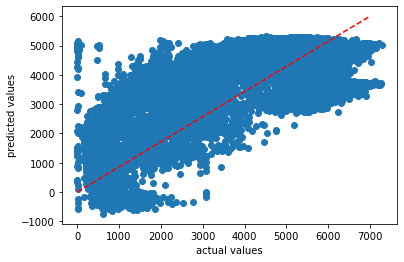

In [160]:
TestPipe(y,y_pred)

### Model is bad, how could I improve it?